In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'USDJPY'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,slope_3,slope_4,slope_5,slope_10,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,109.28,109.80,108.65,108.91,0.0,0.925486,-0.455137,2.297987,3.198588,...,2.696841,3.173551,3.585695,107.677626,1.310779,94.293485,109.545,108.490,109.0175,109.225
30,14/2/2000,108.91,109.07,108.05,108.95,1.0,-0.784407,-1.893300,-2.956038,3.151497,...,3.123521,2.734559,3.211444,107.812297,1.301081,63.217448,109.435,108.350,108.8925,108.560
31,15/2/2000,108.95,109.34,108.47,109.23,1.0,-1.688280,-1.028004,-2.501990,2.923163,...,3.860416,3.388547,2.998586,107.969198,1.299586,74.750444,109.205,108.260,108.7325,108.905
32,16/2/2000,109.23,109.66,108.89,109.43,1.0,3.381735,-0.233010,0.806730,3.329164,...,2.242362,4.050585,3.577851,108.142111,1.299978,87.425169,109.500,108.680,109.0900,109.275
33,17/2/2000,109.43,110.69,109.32,110.55,1.0,1.356420,1.717734,1.561800,3.058058,...,3.000093,3.288798,5.115527,108.409034,1.357558,143.701865,110.175,109.105,109.6400,110.005


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,slope_3,slope_4,slope_5,slope_10,slope_20,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,109.80,109.28,108.65,108.91,0.925486,-0.455137,2.297987,3.198588,3.478849,...,2.696841,3.173551,3.585695,107.677626,1.310779,94.293485,109.545,108.490,109.0175,109.225
30,14/2/2000,109.07,108.91,108.05,108.95,-0.784407,-1.893300,-2.956038,3.151497,3.480951,...,3.123521,2.734559,3.211444,107.812297,1.301081,63.217448,109.435,108.350,108.8925,108.560
31,15/2/2000,109.34,108.95,108.47,109.23,-1.688280,-1.028004,-2.501990,2.923163,3.497893,...,3.860416,3.388547,2.998586,107.969198,1.299586,74.750444,109.205,108.260,108.7325,108.905
32,16/2/2000,109.66,109.23,108.89,109.43,3.381735,-0.233010,0.806730,3.329164,3.498592,...,2.242362,4.050585,3.577851,108.142111,1.299978,87.425169,109.500,108.680,109.0900,109.275
33,17/2/2000,110.69,109.43,109.32,110.55,1.356420,1.717734,1.561800,3.058058,3.464697,...,3.000093,3.288798,5.115527,108.409034,1.357558,143.701865,110.175,109.105,109.6400,110.005


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 10% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.57142857, 0.56769516, 0.56661562, ..., 0.56285739, 0.5651135 ,
        0.56864248],
       [0.55908707, 0.56145675, 0.55640633, ..., 0.5604677 , 0.56298003,
        0.55731562],
       [0.56365173, 0.56213118, 0.56355283, ..., 0.55893147, 0.56024919,
        0.56319196],
       ...,
       [0.55925613, 0.56331141, 0.56542454, ..., 0.56780746, 0.56443079,
        0.56191449],
       [0.5602705 , 0.56229978, 0.56083036, ..., 0.56208927, 0.56101724,
        0.56012604],
       [0.5545224 , 0.55336368, 0.56100051, ..., 0.55987027, 0.55871309,
        0.55731562]])

In [10]:
input_data.shape

(5210, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.57142857, 0.56769516, 0.56661562, ..., 0.56285739, 0.5651135 ,
        0.56864248],
       [0.55908707, 0.56145675, 0.55640633, ..., 0.5604677 , 0.56298003,
        0.55731562],
       [0.56365173, 0.56213118, 0.56355283, ..., 0.55893147, 0.56024919,
        0.56319196],
       ...,
       [0.55925613, 0.56331141, 0.56542454, ..., 0.56780746, 0.56443079,
        0.56191449],
       [0.5602705 , 0.56229978, 0.56083036, ..., 0.56208927, 0.56101724,
        0.56012604],
       [0.5545224 , 0.55336368, 0.56100051, ..., 0.55987027, 0.55871309,
        0.55731562]])

In [13]:
input_data[[0],1:]

array([[0.56769516, 0.56661562, 0.56145675, 0.79655118, 0.49681225,
        0.47110371, 0.54712802, 0.51377132, 0.67392899, 0.5657744 ,
        0.49954016, 0.4932918 , 0.63842645, 0.68193548, 0.68321943,
        0.71725645, 0.59404734, 0.59005235, 0.68193548, 0.68321943,
        0.71725645, 0.64834007, 0.64152014, 0.65097493, 0.68288262,
        0.54594315, 0.76465575, 0.68834445, 0.56658185, 0.56285739,
        0.5651135 , 0.56864248]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.56769516, 0.56661562, 0.56145675, ..., 0.56285739,
          0.5651135 , 0.56864248]],

        [[0.56145675, 0.55640633, 0.56213118, ..., 0.5604677 ,
          0.56298003, 0.55731562]],

        [[0.56213118, 0.56355283, 0.56685213, ..., 0.55893147,
          0.56024919, 0.56319196]],

        ...,

        [[0.48727027, 0.4886847 , 0.4909796 , ..., 0.48041308,
          0.48830859, 0.49003577]],

        [[0.4909796 , 0.49174749, 0.49367729, ..., 0.48894768,
          0.49022871, 0.49071708]],

        [[0.49367729, 0.49634167, 0.50868319, ..., 0.49278826,
          0.49487967, 0.49931869]]],


       [[[0.56145675, 0.55640633, 0.56213118, ..., 0.5604677 ,
          0.56298003, 0.55731562]],

        [[0.56213118, 0.56355283, 0.56685213, ..., 0.55893147,
          0.56024919, 0.56319196]],

        [[0.56685213, 0.57069934, 0.57022425, ..., 0.56610054,
          0.56635091, 0.56949412]],

        ...,

        [[0.4909796 , 0.49174749, 0.49367729, ..., 0.48894768,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4644, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4644/4644 [==============================] - 8s 2ms/step - loss: 0.0143
Epoch 2/5
4644/4644 [==============================] - 7s 1ms/step - loss: 6.1144e-04
Epoch 3/5
4644/4644 [==============================] - 7s 2ms/step - loss: 4.518

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([108.78, 107.9 , 107.02, 106.4 , 106.73, 107.38, 107.9 , 107.78,
       107.13, 107.27, 107.68, 107.53, 107.2 , 106.29, 106.24, 106.46,
       106.22, 106.32, 107.05, 106.97, 107.29, 106.75, 106.41, 106.38,
       106.31, 106.61, 106.64, 106.09, 105.37, 105.48, 105.9 , 107.01,
       106.93, 106.54, 106.45, 106.66, 106.85, 107.49, 107.46, 107.2 ,
       107.4 , 107.26, 107.43, 107.78, 107.61, 107.21, 107.39, 107.52,
       107.86, 108.75, 109.2 , 109.45, 109.47, 109.54, 109.45, 109.89,
       110.04, 109.92, 109.27, 109.4 , 109.35, 109.83, 110.02, 109.57,
       109.67, 110.45, 110.41, 110.86, 111.08, 111.4 , 111.19, 110.92,
       110.12, 109.74, 109.83, 109.47, 109.07, 109.  , 109.73, 109.85,
       110.  , 110.27, 110.22, 109.85, 110.12, 110.49, 110.85, 110.69,
       110.9 , 110.74, 110.57, 110.45, 110.76, 110.22, 110.04, 110.22,
       110.49, 110.65, 110.94, 111.06, 111.14, 110.61, 110.72, 110.79,
       110.9 , 111.35, 112.17, 112.63, 112.8 , 112.56, 112.93, 113.14,
      

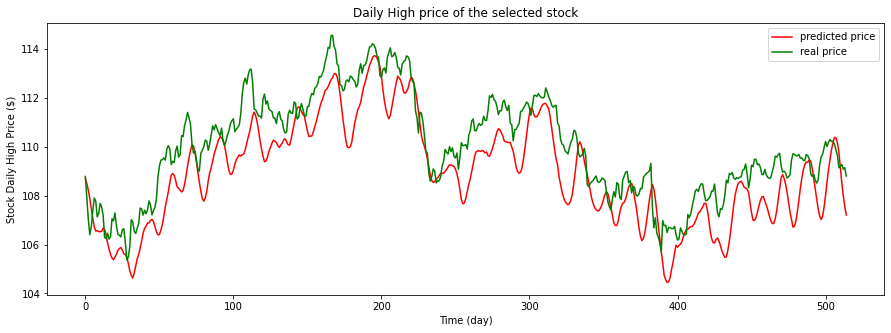

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,108.78,108.703126,NaN,NaN
1,107.90,108.490497,108.703126,-0.212630
2,107.02,108.219042,108.490497,-0.271455
3,106.40,107.879680,108.219042,-0.339362
4,106.73,107.465889,107.879680,-0.413791
...,...,...,...,...
510,109.20,109.141149,109.784475,-0.643326
511,109.27,108.505378,109.141149,-0.635771
512,109.08,107.989006,108.505378,-0.516372
513,109.14,107.539363,107.989006,-0.449643


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,108.78,108.703126,NaN,NaN,NaN,107.9575,NaN
1,107.90,108.490497,108.703126,-0.212630,-0.394124,107.1600,-0.007387
2,107.02,108.219042,108.490497,-0.271455,-0.507297,106.3300,-0.007745
3,106.40,107.879680,108.219042,-0.339362,-0.637898,106.1275,-0.001904
4,106.73,107.465889,107.879680,-0.413791,-0.775397,106.5025,0.003533
5,107.38,107.069579,107.465889,-0.396311,-0.738146,107.1500,0.006080
6,107.90,106.730157,107.069579,-0.339422,-0.629141,107.6850,0.004993
7,107.78,106.551232,106.730157,-0.178925,-0.332019,106.9700,-0.006640
8,107.13,106.564055,106.551232,0.012823,0.023939,106.8450,-0.001169
9,107.27,106.530893,106.564055,-0.033162,-0.061829,106.8775,0.000304


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

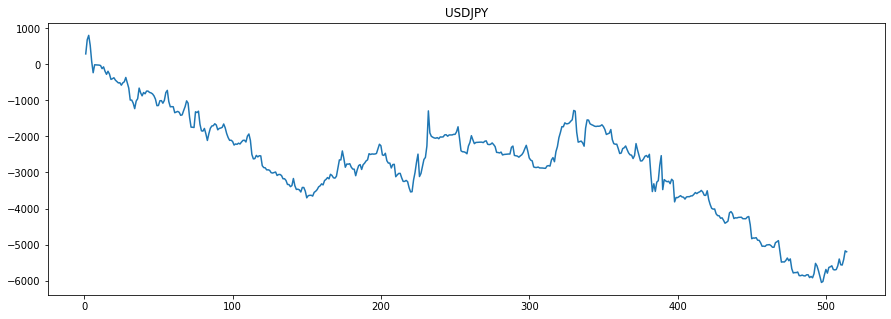

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.title(currency_name)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

-1.0727139436737472

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

0.9766536964980544

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 0 , from day 2 , to day 0
